# This notebook aims to create and train a model to steer a car 

The first step will be to apply all data management done in the EDA notebook

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Cropping2D, Lambda, Conv2D, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
%matplotlib inline

In [2]:
# reading 1st scenario backward data
root_folter = './data/'
data_Folder = root_folter+'data_1st_scenario_backward/driving_log.csv'
df_1st_bwd = pd.read_csv(data_Folder, names=['center image path', 'left image path', 'right image path', 
                                                'steering angle', 'Throttle value','Break value',
                                               'speed'])
# reading 1st scenario forward data
data_Folder = root_folter+'data_1st_scenario_forward/driving_log.csv'
df_1st_fwd = pd.read_csv(data_Folder, names=['center image path', 'left image path', 'right image path', 
                                                'steering angle', 'Throttle value','Break value',
                                               'speed'])
# reading 2nd scenario forward data
data_Folder = root_folter+'dataset_2nd_scenario_forward/driving_log.csv'
df_2nd_fwd = pd.read_csv(data_Folder, names=['center image path', 'left image path', 'right image path', 
                                                'steering angle', 'Throttle value','Break value',
                                               'speed'])

## Get rid of some data since most of the steering angles are around zero. 

We want a more even dataset that's why we take only `high_limit` samples from zero steering as explained in the EDA.

In [3]:
high_limit = 500
# 1st scenario backward
number_to_drop = len(df_1st_bwd[df_1st_bwd['steering angle']==0.0])-high_limit
df_1st_bwd.drop(df_1st_bwd[df_1st_bwd['steering angle']==0.0].sample(number_to_drop).index, inplace=True)
# 1st scenario forward
number_to_drop = len(df_1st_fwd[df_1st_fwd['steering angle']==0.0])-high_limit
df_1st_fwd.drop(df_1st_fwd[df_1st_fwd['steering angle']==0.0].sample(number_to_drop).index, inplace=True)
# 2nd scenario forward
number_to_drop = len(df_2nd_fwd[df_2nd_fwd['steering angle']==0.0])-high_limit
df_2nd_fwd.drop(df_2nd_fwd[df_2nd_fwd['steering angle']==0.0].sample(number_to_drop).index, inplace=True)

In [4]:
# Joining the dataframes into one
df = pd.concat([df_1st_bwd, df_1st_fwd, df_2nd_fwd], ignore_index=True)

## Preparing data generators

To create the data generators we will take into account the three cameras aboard our car.

#### Multiple camera usage

As we noticed in the EDA, we have 3 cameras mounted in the car. Left, center and right cameras. However we have only one steering measurement. The reason is that we only need one and the other ones can be calculated based on trigonometry. However, in this exercise we will we lazy and just pick one and tune it with a trial and error process. To best illustrate the idea please refer to the below image:

<img src="./figures/figure1.JPG">


In [5]:
def get_images(image_paths:np.array):
    """
        This functions gets a numpy array of image paths and returns
        a numpy array of BGR images
    """
    images = []
    for path in image_paths:
        images.append(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
    return np.array(images)

In [6]:
def batch_generator(dataframe: pd.core.frame.DataFrame, batch_size: int, correction_factor = 0.2):
    """
        This generator creates batches from all dataframe based on the batch size
        
        @params dataframe: pandas dataframe that contains all data and steering labels 
        @params batch_size: integer that sets the number of batches to which our data will be split on
        @yield batch: each iteration our generator yields a random batch
    """
    
    if type(dataframe) != pd.core.frame.DataFrame:
        raise ValueError('the input to batch_generator is not a pandas dataframe')
    while 1: # Loop forever so the generator never terminates
        temp_df = dataframe.sample(batch_size)
        # getting steering angles for the 3 cameras
        center_steer_angles = np.array(temp_df['steering angle'])
        left_steer_angles = center_steer_angles + correction_factor
        right_steer_angles = center_steer_angles - correction_factor
        # getting image paths for the 3 cameras
        center_image_paths = np.array(temp_df['center image path'])
        left_image_paths = np.array(temp_df['left image path'])
        right_image_paths = np.array(temp_df['right image path'])
        # getting images from image paths
        center_images = get_images(center_image_paths)
        left_images = get_images(left_image_paths)
        right_images = get_images(right_image_paths)
        
        batch_Y = np.concatenate([center_steer_angles, left_steer_angles, right_steer_angles])
        batch_X = np.concatenate([center_images, left_images, right_images])
        yield shuffle(batch_X, batch_Y)

#### Let's 1st split data into training and validation

In [7]:
train_df, validation_df = train_test_split(df, test_size=0.2)

#### Creating generators

In [8]:
batch_size = 10
val_generator = batch_generator(validation_df, batch_size)
train_generator = batch_generator(train_df, batch_size)

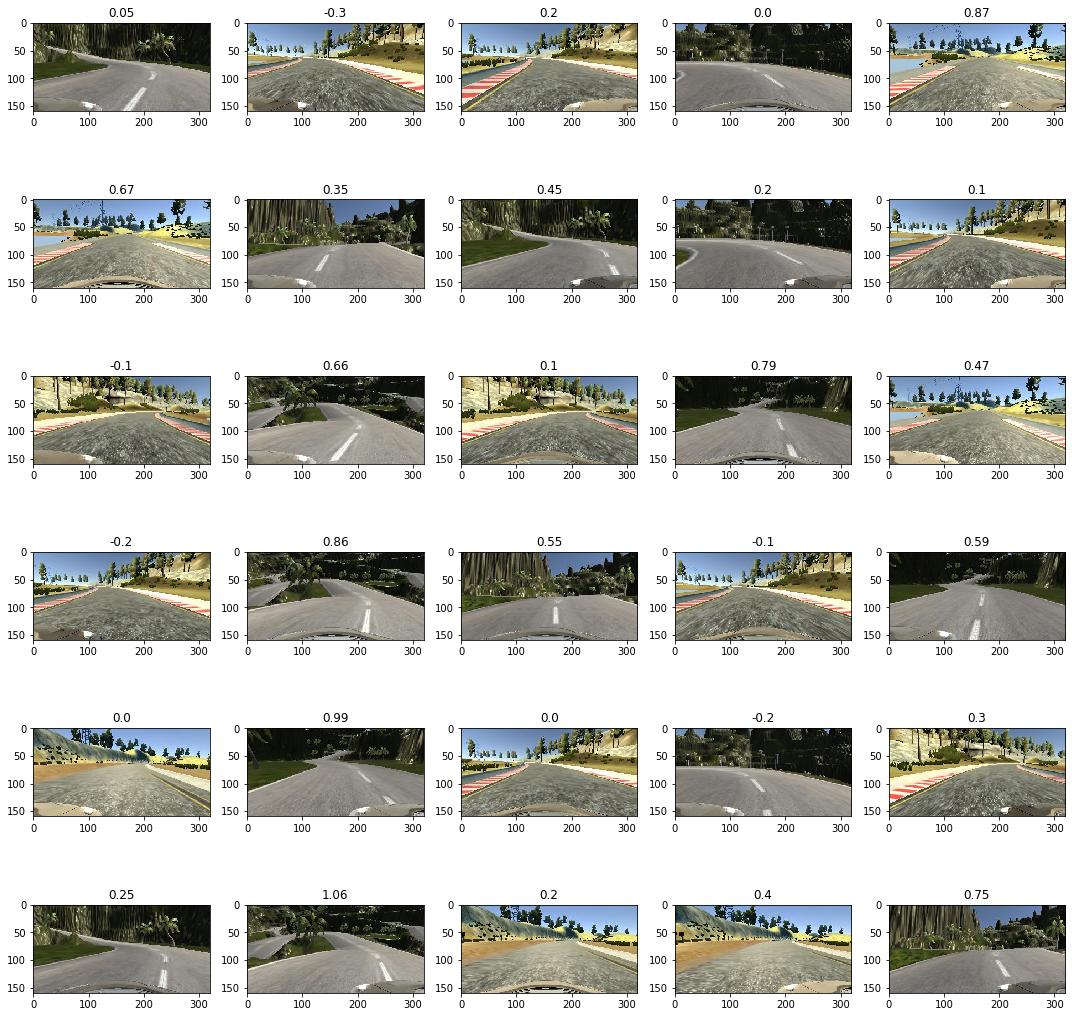

In [9]:
images, labels = next(train_generator)

fig = plt.figure(figsize=(15,15))
i=1
for img, label in zip(images, labels):
    plt.subplot(6,5,i)
    i=i+1
    plt.imshow(img)
    plt.title(str(round(label,2)))
fig.tight_layout()
plt.show()

# Build model

In [48]:
model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3)))
# cropping the model to get rid of unnecessary background
model.add(Cropping2D(cropping=((60,20), (0,0))))
# Start architecture here
model.add(Conv2D(24,kernel_size=(5,5),strides=(2,2),activation='relu'))
model.add(Conv2D(36,kernel_size=(5,5),strides=(2,2),activation='relu'))
model.add(Conv2D(48,kernel_size=(5,5),strides=(2,2),activation='relu'))
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu'))
model.add(Conv2D(64,kernel_size=(3,3),strides=(1,1),activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_18 (Lambda)           (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_17 (Cropping2D)   (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 38, 158, 24)       1824      
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 17, 77, 36)        21636     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 7, 37, 48)         43248     
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 5, 35, 64)         27712     
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 3, 33, 64)         36928     
__________

In [53]:
model_path="model.h5"

checkpoint = ModelCheckpoint(model_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = False,
                              period=3)

early_stop = EarlyStopping(monitor='val_loss', 
                       mode= 'min', 
                       patience=2)


callbacks_list = [checkpoint, early_stop]

model.compile(loss='mse', optimizer='adam')
history=model.fit_generator(train_generator, 
            steps_per_epoch=np.ceil(len(train_df)/batch_size), 
            validation_data=val_generator, 
            validation_steps=np.ceil(len(validation_df)/batch_size), 
            epochs=5, verbose=1, callbacks=callbacks_list)

Epoch 1/5
  2/810 [..............................] - ETA: 11:53 - loss: 0.2892

KeyboardInterrupt: 